In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示符号
import datetime
WHICH_PT = '20191104.csv'

In [2]:
# 读取所有的表格并且输出表格的信息
teacher_df = pd.read_csv(f'teacher_{WHICH_PT}')
class_df = pd.read_csv(f'class_{WHICH_PT}')
cg_df = pd.read_csv(f'cg_{WHICH_PT}')
for i in [teacher_df, cg_df, class_df]:
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551733 entries, 0 to 3551732
Data columns (total 6 columns):
t.teacher_id           int64
t.teacher_show_name    object
t.life_cycle           object
t.student_favorite     float64
t.apple_score          float64
t.entry_date           object
dtypes: float64(2), int64(1), object(3)
memory usage: 162.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710766 entries, 0 to 710765
Data columns (total 6 columns):
s.student_id          710766 non-null int64
cg.staff_id           710766 non-null int64
cg.staff_name         710766 non-null object
cg.tl_master_id       710548 non-null float64
cg.mgr_master_name    710721 non-null object
cg.dept_team_name     710738 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 32.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12343379 entries, 0 to 12343378
Data columns (total 6 columns):
s.student_id              int64
oc.online_class_id        int64
oc.scheduled_date_time 

In [3]:
class_df['oc.scheduled_date_time'] = class_df['oc.scheduled_date_time'].astype('datetime64')
class_df['oc.book_date_time'] = class_df['oc.book_date_time'].astype('datetime64')
class_df.drop(columns=['oc.book_operator_dtpye', 'oc.online_class_id',], inplace=True)

In [16]:
# 1234万节课，71万个学生， 355万个外教, 其中 8 9 月上课的外教数为 78914
# 看一下这两月上课的外教有多少
# teacher_set = list(class_df['oc.teacher_id'].drop_duplicates())
# print(len(teacher_set))
# 找一下上课最多的外教们都上了多少节课
teacher_pivot = pd.pivot_table(class_df, values='oc.online_class_id', aggfunc=np.count_nonzero, index='oc.teacher_id')
teacher_pivot.sort_values(by='oc.online_class_id', ascending=False, inplace=True)
teacher_pivot = teacher_pivot.merge(teacher_df, how='left', left_index=True, right_on='t.teacher_id')
teacher_pivot.to_csv('teacher_class_num.csv')

In [21]:
teacher_pivot.corr()

,oc.online_class_id,t.teacher_id,t.student_favorite,t.apple_score
oc.online_class_id,1.000000,-0.295435,0.331400,0.112084
t.teacher_id,-0.295435,1.000000,-0.446429,-0.061200
t.student_favorite,0.331400,-0.446429,1.000000,0.043547
t.apple_score,0.112084,-0.061200,0.043547,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F8BA40EB38>,
      dtype=object)

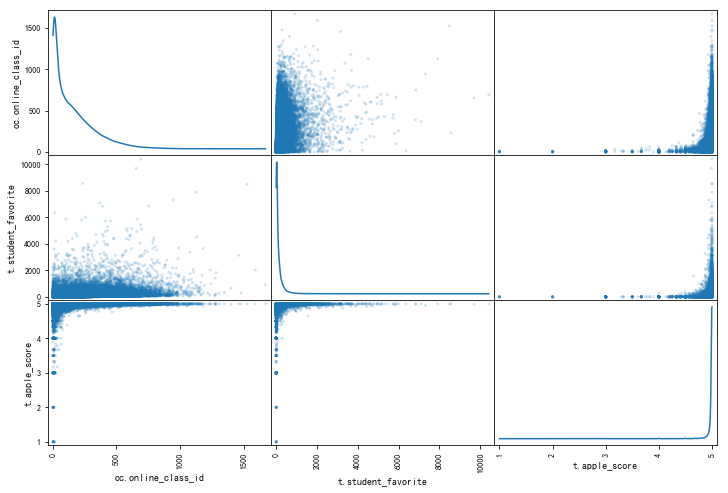

In [33]:
from pandas.plotting import scatter_matrix
scatter_matrix(teacher_pivot[['oc.online_class_id', 't.student_favorite', 't.apple_score']], figsize=(12, 8), diagonal = 'kde', alpha=0.2)

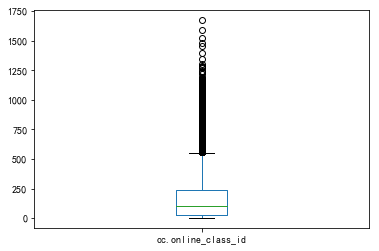

In [29]:
teacher_pivot['oc.online_class_id'].plot.box()

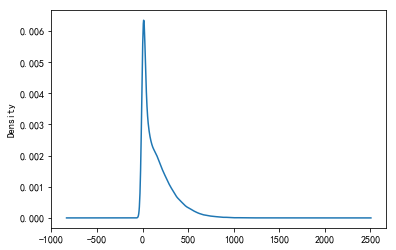

In [32]:
teacher_pivot['oc.online_class_id'].plot(kind='kde')

In [20]:
teacher_pivot = pd.read_csv('teacher_class_num.csv')
# 优秀的老师列表，三个月上课量大于450的，共有5240左右
excelent_teacher_set = list(teacher_pivot[teacher_pivot['oc.online_class_id'] > 450]['t.teacher_id']) 
# teacher_pivot[teacher_pivot['oc.online_class_id'] > 1000]['oc.online_class_id'].sum()

In [17]:
teacher_pivot[teacher_pivot['oc.online_class_id'] > 450]['oc.online_class_id'].sum()

3096128

In [5]:
len(excelent_teacher_set)

5240

In [20]:
excelent_class_df = class_df[class_df['oc.teacher_id'].isin(excelent_teacher_set)]
excelent_class_df.info()
excelent_class_df = excelent_class_df.merge(cg_df[['s.student_id', 'cg.dept_team_name']], on='s.student_id', how='left')
excelent_dpt_pivot = pd.pivot_table(excelent_class_df, values='oc.online_class_id', aggfunc=np.count_nonzero,
               index='cg.dept_team_name', fill_value=0) # 透视出各个部优秀的外教数量
excelent_dpt_pivot.to_csv('excelent_class_num_df.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3096128 entries, 0 to 12343264
Data columns (total 6 columns):
s.student_id              int64
oc.online_class_id        int64
oc.scheduled_date_time    object
oc.teacher_id             int64
oc.book_date_time         object
oc.book_operator_dtpye    object
dtypes: int64(3), object(3)
memory usage: 165.4+ MB


In [21]:
excelent_class_df = class_df[~class_df['oc.teacher_id'].isin(excelent_teacher_set)]
excelent_class_df = excelent_class_df.merge(cg_df[['s.student_id', 'cg.dept_team_name']], on='s.student_id', how='left')
excelent_dpt_pivot = pd.pivot_table(excelent_class_df, values='oc.online_class_id', aggfunc=np.count_nonzero,
               index='cg.dept_team_name', fill_value=0) # 透视出各个部优秀的外教数量
excelent_dpt_pivot.to_csv('un_excelent_class_num_df.csv')

In [22]:
# 画一下各部的优秀和非优秀的堆积柱状图
excelent_dpt_pivot = pd.read_csv('excelent_class_num_df.csv')
un_excelent_dpt_pivot = pd.read_csv('un_excelent_class_num_df.csv')
dpt_df = pd.merge(excelent_dpt_pivot, un_excelent_dpt_pivot, how='left', on='cg.dept_team_name')

In [36]:
dpt_df['rate'] = dpt_df['oc.online_class_id_x']/(dpt_df['oc.online_class_id_x']+dpt_df['oc.online_class_id_y'])

c:\users\zouyun\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
dpt_list = ['上海',
 '北京一部',
 '北京二部',
 '大连',
 '成都一部',
 '成都二部',
 '高级别服务部']

In [29]:
dpt_df = dpt_df[dpt_df['cg.dept_team_name'].isin(dpt_list)]

In [37]:
dpt_df

,cg.dept_team_name,oc.online_class_id_x,oc.online_class_id_y,rate
0,上海,346378,969341,0.263261
2,北京一部,610895,1798032,0.253596
3,北京二部,630712,1857862,0.253443
7,大连,403652,1305440,0.236179
9,成都一部,405892,1181151,0.255754
10,成都二部,457018,1373026,0.249731
15,高级别服务部,48334,115995,0.294129


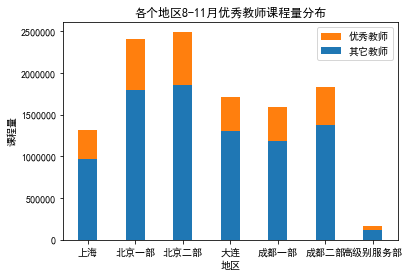

In [38]:
un_excelent_class_list = list(dpt_df['oc.online_class_id_y'])
excelent_class_list = list(dpt_df['oc.online_class_id_x'])
ind = np.arange(7)
width = 0.4
p1 = plt.bar(ind, un_excelent_class_list, width, )
p2 = plt.bar(ind, excelent_class_list, width,
             bottom=un_excelent_class_list,)
plt.ylabel('课程量')
plt.xlabel('地区')
plt.title('各个地区8-11月优秀教师课程量分布')
plt.xticks(ind, list(dpt_df['cg.dept_team_name']))
plt.legend((p2[0], p1[0]), ('优秀教师', '其它教师'))
plt.show()

In [3]:
# 透视出所有学生的课消，算出所有学生的优秀外教课消数量，查看相关性，是不是课消越多，优秀外教就越多
# class_df[['s.student_id','oc.teacher_id']]
student_pivot_df = pd.pivot_table(class_df[['s.student_id','oc.teacher_id']], values='oc.teacher_id',
                                  index='s.student_id', aggfunc=np.count_nonzero)
student_pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664987 entries, 841 to 42339060
Data columns (total 1 columns):
oc.teacher_id    664987 non-null int64
dtypes: int64(1)
memory usage: 10.1 MB


In [4]:
student_pivot_df.to_csv('student_all_class_num.csv')

In [11]:
student_pivot_df = pd.pivot_table(class_df[class_df['oc.teacher_id'
                                                   ].isin(excelent_teacher_set)][['s.student_id','oc.teacher_id']],
                                  values='oc.teacher_id',
                                  index='s.student_id', aggfunc=np.count_nonzero)
student_pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416411 entries, 841 to 42338462
Data columns (total 1 columns):
oc.teacher_id    416411 non-null int64
dtypes: int64(1)
memory usage: 6.4 MB


In [12]:
student_pivot_df.to_csv('student_excelent_class_num.csv')

In [17]:
# 合并两个表的数据
student_class_num_df = pd.merge(pd.read_csv('student_all_class_num.csv'), pd.read_csv('student_excelent_class_num.csv'),
                               on='s.student_id', how='left')

In [19]:
student_class_num_df.fillna(0, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D2E0B2BE0>,
      dtype=object)

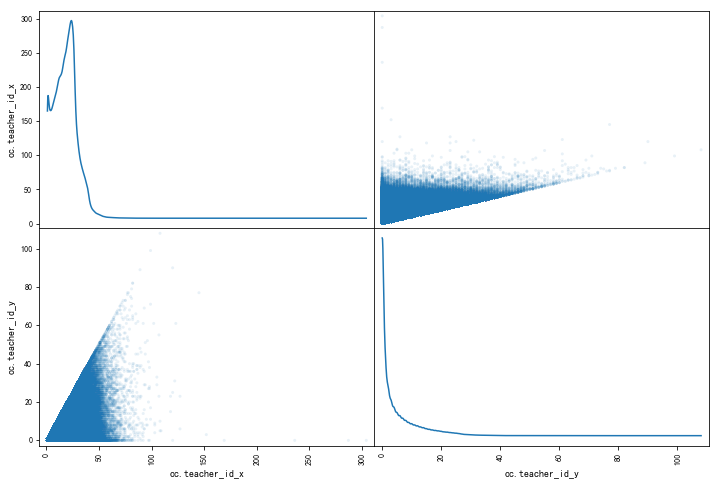

In [22]:
from pandas.plotting import scatter_matrix
scatter_matrix(student_class_num_df[['oc.teacher_id_x', 'oc.teacher_id_y']], figsize=(12, 8), diagonal = 'kde', alpha=0.1)

In [5]:
# 计算每一节课的上课时间-约课时间的天数
# 匹配出优秀老师和非优秀老师，之后透视一下，然后看看核密度估计图
def get_days(x, y):
    return (x-y).days
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12343379 entries, 0 to 12343378
Data columns (total 4 columns):
s.student_id              int64
oc.scheduled_date_time    datetime64[ns]
oc.teacher_id             int64
oc.book_date_time         datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 376.7 MB


In [15]:
class_df['sub_days'] = class_df.apply(lambda x: get_days(
    x['oc.scheduled_date_time'], x['oc.book_date_time']), axis=1)

In [19]:
class_df.to_csv('sub_days_book_and_scheduled.csv', index=False)

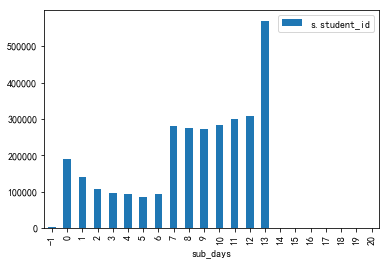

In [36]:
excelent_sub_days_csv = pd.pivot_table(class_df[class_df['oc.teacher_id'].isin(excelent_teacher_set)],
                                      index='sub_days', aggfunc=np.count_nonzero, values='s.student_id')
excelent_sub_days_csv.plot(kind='bar')    # 优秀老师的约课时间分布

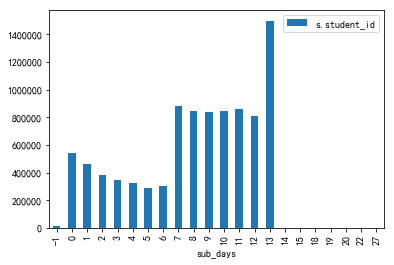

In [37]:
excelent_sub_days_csv = pd.pivot_table(class_df[~class_df['oc.teacher_id'].isin(excelent_teacher_set)],
                                      index='sub_days', aggfunc=np.count_nonzero, values='s.student_id')
excelent_sub_days_csv.plot(kind='bar')    # 非优秀老师的约课时间分布

In [39]:
# 看一下各部的 约课时间快慢问题
class_df = class_df.merge(cg_df[['s.student_id', 'cg.dept_team_name']], on='s.student_id', how='left')

In [41]:
df_list = []
for i in dpt_list:
    df_list.append(pd.pivot_table(class_df[class_df['cg.dept_team_name']==i],
                                  index='sub_days', aggfunc=np.count_nonzero,
                                  values='s.student_id').rename(columns={'s.student_id': i}))
df = pd.concat(df_list, axis=1)

In [46]:
df.drop(columns='高级别服务部', inplace=True)

In [65]:
for i in df.columns:
    df[i] = df[i]/df[i].sum()

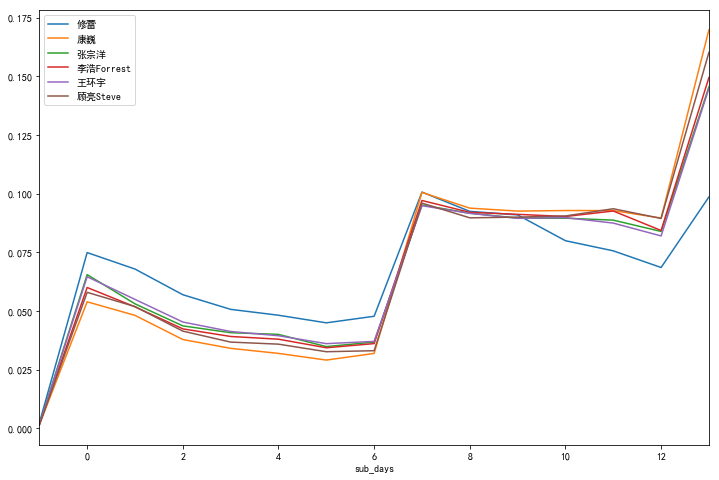

In [66]:
df.plot(figsize=(12, 8))

In [60]:
# 看一下各部的 约课时间快慢问题
class_df = class_df.merge(cg_df[['s.student_id', 'cg.mgr_master_name']], on='s.student_id', how='left')

In [62]:
set(class_df[class_df['cg.dept_team_name']=='大连']['cg.mgr_master_name'])

{'修蕾', '康巍', '张宗洋', '李浩Forrest', '王环宇', '顾亮EA', '顾亮Steve'}

In [63]:
dl_mgr_set = ['修蕾', '康巍', '张宗洋', '李浩Forrest', '王环宇', '顾亮Steve']
df_list = []
for i in dl_mgr_set:
    df_list.append(pd.pivot_table(class_df[class_df['cg.mgr_master_name']==i],
                                  index='sub_days', aggfunc=np.count_nonzero,
                                  values='s.student_id').rename(columns={'s.student_id': i}))
df = pd.concat(df_list, axis=1)

,修蕾,康巍,张宗洋,李浩Forrest,王环宇,顾亮Steve
sub_days,,,,,,
-1,214,480,440,598,612,345
0,7171,17602,17335,22232,25401,14946
1,6499,15715,14038,19180,21606,13383
2,5451,12354,11552,15699,17813,10684
3,4854,11125,10782,14498,16224,9477
4,4614,10423,10592,14069,15514,9251
5,4304,9493,9216,12714,14189,8418
6,4572,10417,9721,13373,14563,8532
7,9640,32821,25177,35969,37311,24758
